In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_data_point = session.query(Measurement.date).\
                order_by(Measurement.date.desc()).first()
print(f"The last data point is on {last_data_point[0]}")

end_date = datetime.strptime(last_data_point[0], '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=366)
print(f"Searching all dates between {start_date} and {end_date}")

# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

query_results_df = pd.DataFrame(query_results)
query_results_df.set_index('date', inplace=True)
query_results_df.rename(columns = {'prcp': 'precipitation'}, inplace=True)
query_results_df.head(15)

The last data point is on 2017-08-23
Searching all dates between 2016-08-22 00:00:00 and 2017-08-23 00:00:00


,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


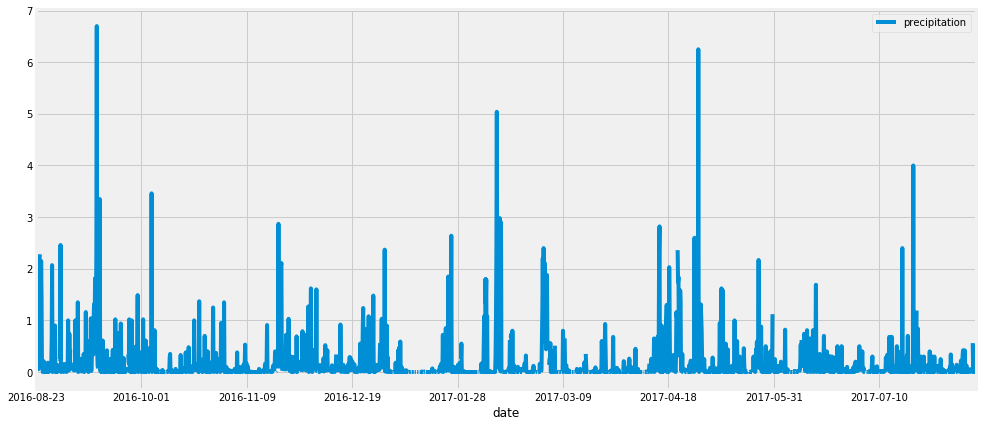

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

query_results_df.plot(figsize=(15,7))
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

query_results_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(func.count(Station.name)).all()
print(f"There are a total of {station_count[0][0]} weather stations.")

There are a total of 9 weather stations.


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

activity_count = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
activity_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Most active station (highest number of temp observations)
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()
print(f"The station with the highest number of observations is {most_active_station[0]}.")

#Low , High, and avg of above station
temp_high = session.query(Measurement.station, Measurement.tobs).\
            filter(Measurement.station == "USC00519281").\
            order_by(Measurement.tobs.desc()).first()
print(f"The highest recorded temperature was {temp_high[1]} degrees.")
temp_low = session.query(Measurement.station, Measurement.tobs).\
            filter(Measurement.station == "USC00519281").\
            order_by(Measurement.tobs).first()
print(f"The lowest recorded temperature was {temp_low[1]} degrees.")
temp_avg = session.query(Measurement.station, func.avg(Measurement.tobs)).\
            filter(Measurement.station == "USC00519281").all()
print(f"The average temperatue was {temp_avg[0][1]} degrees.")

The station with the highest number of observations is USC00519281.
The highest recorded temperature was 85.0 degrees.
The lowest recorded temperature was 54.0 degrees.
The average temperatue was 71.66378066378067 degrees.


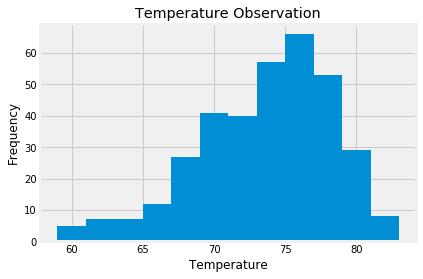

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

temp_data_list = list(np.ravel(temp_data))
plt.hist(temp_data_list, bins=12)
plt.title("Temperature Observation")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# parse out the month & day from our trip dates
trip_start = datetime.strptime('2020-02-28', "%Y-%m-%d")
trip_end = datetime.strptime('2020-03-05', "%Y-%m-%d")

query_start_date = datetime.strftime(start_date, '%Y') + "-" + datetime.strftime(trip_start, '%m-%d')
query_end_date = datetime.strftime(end_date, '%Y') + "-" + datetime.strftime(trip_end, '%m-%d')

calc_temp_results = calc_temps(query_start_date, query_end_date)
print(calc_temp_results)

[(59.0, 74.11674478057094, 84.0)]


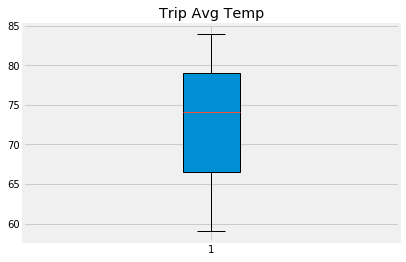

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

calc_temp_results_list = list(np.ravel(calc_temp_results))

fig, ax = plt.subplots()
x = range(len(calc_temp_results_list))
ax.boxplot(calc_temp_results_list, patch_artist=True)
ax.set_title('Trip Avg Temp')
plt.show()

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rpws = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp),
                    Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= query_start_date).\
        filter(Measurement.date <= query_end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
rpws

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  173.84,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  89.39000000000003,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  62.55000000000002,
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  40.01,
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  32.29,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  22.129999999999995,
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', 'PEARL CITY, HI US', 6.17, 21.3934, -157.9751, 11.9)]